In [1]:
#!pip install scikit-learn --upgrade

In [2]:
#!python -V

# Исследование пиковой нагрузки компании «Чётенькое такси»

    Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.
    Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Шаг 1. Загрузите и подготовьте данные.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    recall_score
)
from sklearn.pipeline import(
    Pipeline, # Pipeline с ручным вводом названий шагов.
    make_pipeline # Pipeline с автоматическим названием шагов.
    )
from time import time
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize'] = [10, 4]

Загрузим данные.

In [4]:
try:
    data = pd.read_csv('C:/Users/almuc/Downloads/taxi.csv', decimal = ',', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', decimal = ',', index_col=[0], parse_dates=[0])

Сделаем сортировку по индексу.

In [5]:
data.sort_index(inplace=True)

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице 26496 строк, и 1 столбец с количеством заказов. В индексе указана дата и время заказа. Заказы указаны за период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00. Интервал заказов 10 минут. Пропусков нет. 

## Шаг 2. Анализ данных.

Проверим данные на наличие явных дуликатов.

In [8]:
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 26415


Почти весь датафрейм состоит из дубликатов. Думаю это не дубликаты, а просто он не учитывает время. Оставим все как есть.

Выполним ресемплирование по 1 часу.

In [9]:
data = data.resample('1H').sum()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Количество строк уменьшилось ровно в 6 раз, значит все прошло успешно.

Построим график.

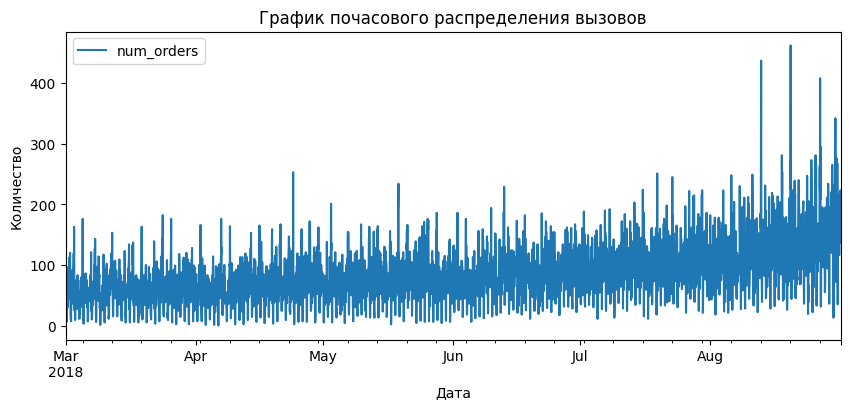

In [11]:
data.plot()
plt.title("График почасового распределения вызовов")
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Изначально с марта по июль особой разницы не наблюдается, количество заказов примерно одинаковое. В августе же количество заказов значительно выросло. Предполагаю, что это связано с каким-то внешним фактором. Нужно уточнить информацию у заказчика.

Думаю нелишним будет постороить помесячное распределение.

In [12]:
month = data.resample('1M').sum()

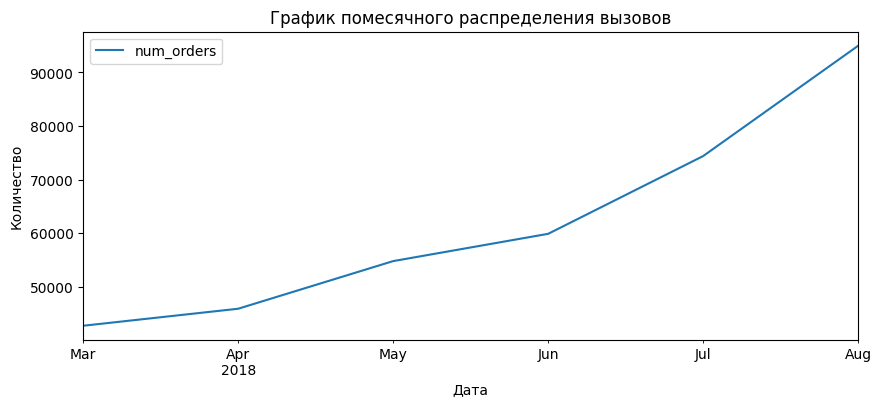

In [13]:
month.plot()
plt.title("График помесячного распределения вызовов")
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

Действительно наблюдается рост заказов, это хороший показатель, означающий, что компания развивается.

Теперь для верной оценки нужно взять в работу последнюю неделю работы, предъыдущие данные оценивать не стоит, т.к. для анализа времени достаточно 1 недели.

In [14]:
df = data['2018-08-25':'2018-08-31']

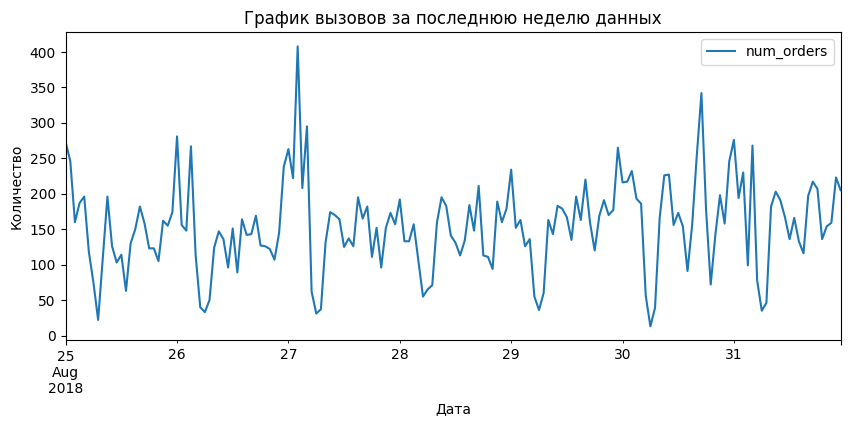

In [15]:
df.plot()
plt.title("График вызовов за последнюю неделю данных")
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

По графику видно, что натступают часы ПИК а также время когда вызовов практически нет. Для наглядности думаю сделать ежедневное распределение вызовов.

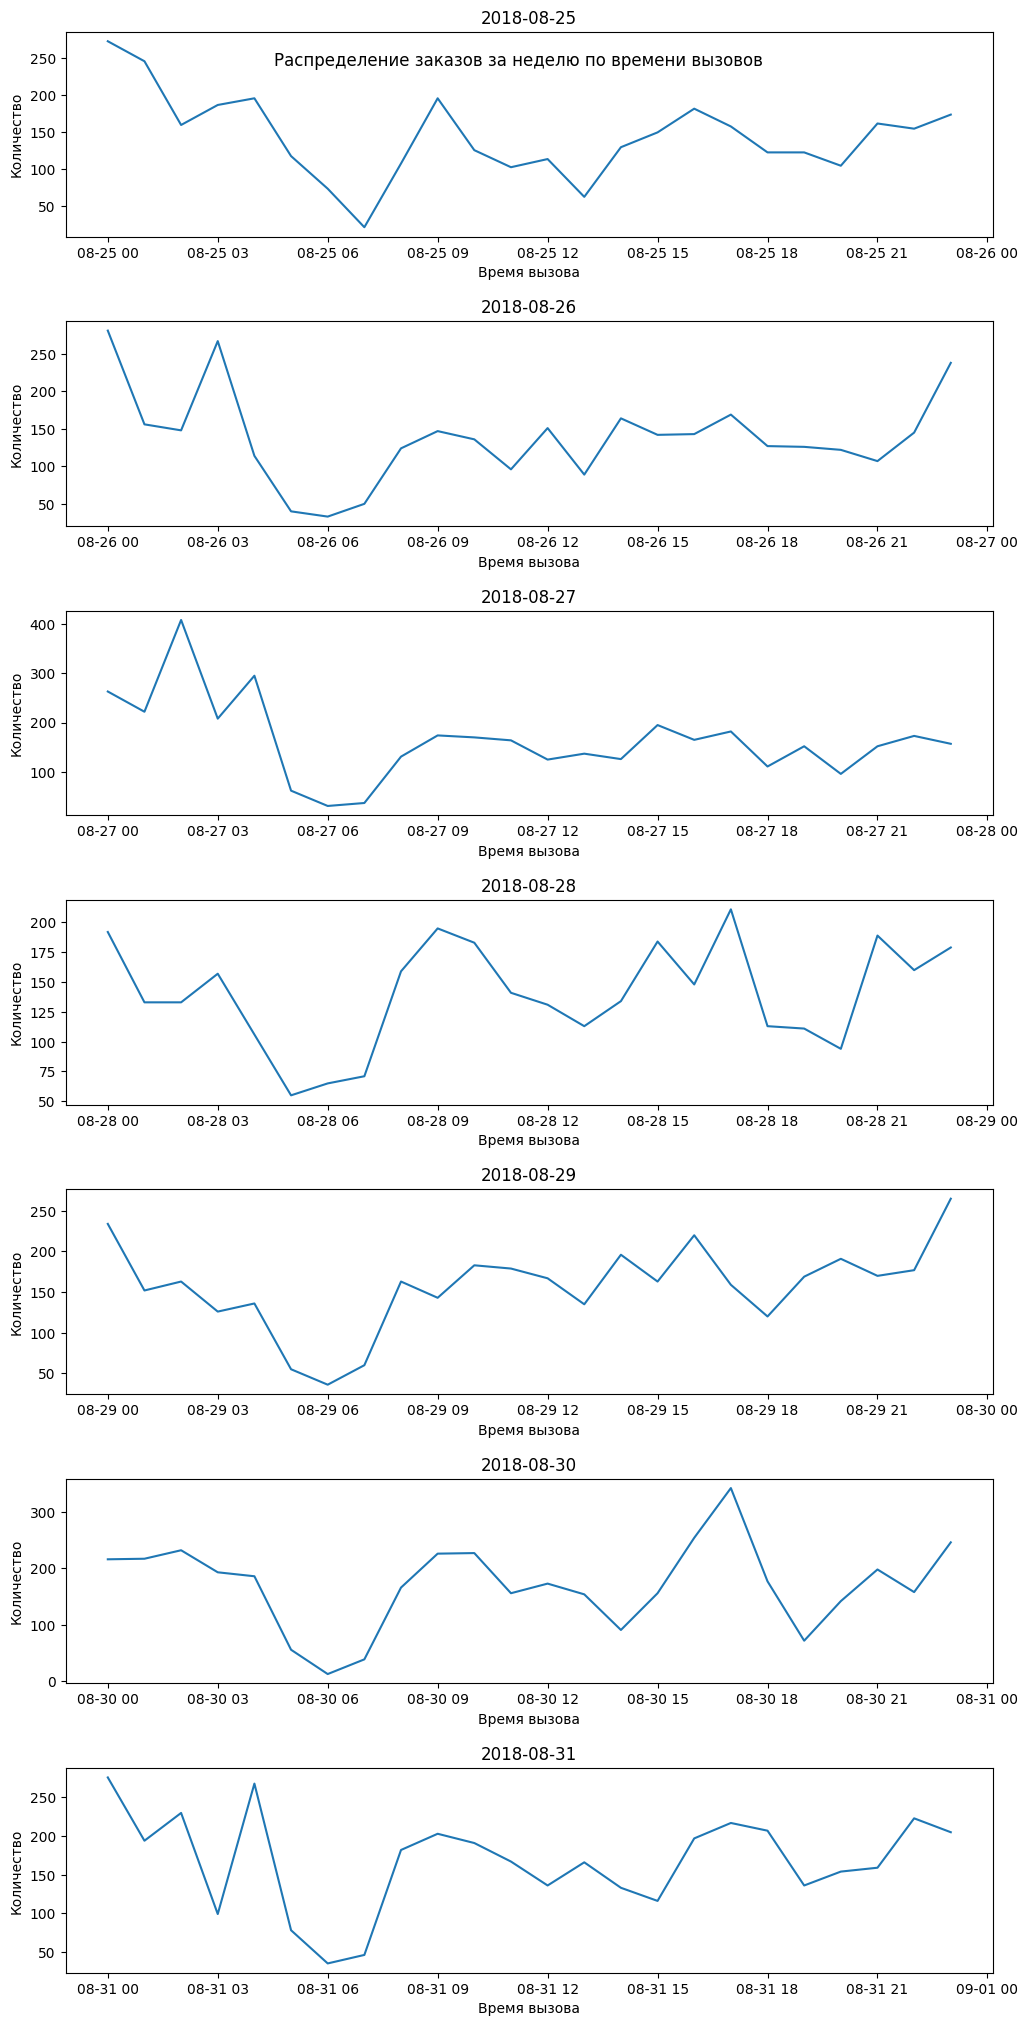

In [16]:
fig, axs = plt.subplots(nrows= 7 , ncols= 1, figsize=(10, 20))
fig.tight_layout(h_pad= 4)
plt.suptitle('Распределение заказов за неделю по времени вызовов')

axs[0].plot(df['2018-08-25'])
axs[0].set_title('2018-08-25') 
axs[0].set_xlabel('Время вызова')
axs[0].set_ylabel('Количество')
 
axs[1].plot(df['2018-08-26'])
axs[1].set_title('2018-08-26') 
axs[1].set_xlabel('Время вызова')
axs[1].set_ylabel('Количество')

axs[2].plot(df['2018-08-27'])
axs[2].set_title('2018-08-27') 
axs[2].set_xlabel('Время вызова')
axs[2].set_ylabel('Количество')


axs[3].plot(df['2018-08-28'])
axs[3].set_title('2018-08-28') 
axs[3].set_xlabel('Время вызова')
axs[3].set_ylabel('Количество')

axs[4].plot(df['2018-08-29'])
axs[4].set_title('2018-08-29') 
axs[4].set_xlabel('Время вызова')
axs[4].set_ylabel('Количество')

axs[5].plot(df['2018-08-30'])
axs[5].set_title('2018-08-30') 
axs[5].set_xlabel('Время вызова')
axs[5].set_ylabel('Количество')

axs[6].plot(df['2018-08-31'])
axs[6].set_title('2018-08-31') 
axs[6].set_xlabel('Время вызова')
axs[6].set_ylabel('Количество')
plt.show()

На графиках прослеживается одна очень важная тенденция. После 21-00 и до 05-00 большое количество вызовов такси, в то же время ежедневно в 6-00 наблюдается очень сильный спад заказов. Думаю это связано с работой общественного транспорта, который как раз в 06-00 начинает свою работу и заканчивает в 21-00. Ночью насколько мне известно общественный транспорт тоже ходит в аэропорт и наверное с этим связан спад заказов в определенные часы (около 2-х часов ночи).

**Рассмотрим тренды, сезонность, остаток декомпозиции заказа такси**

Построим графики тренда, сезонности и резистентности за весь исследуемый период.

In [17]:
decomposed = seasonal_decompose(data)

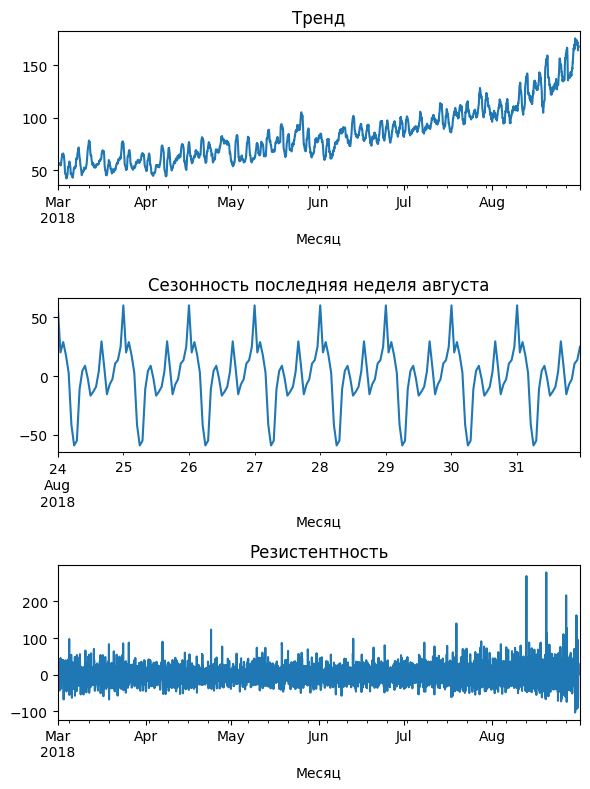

In [18]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Месяц')
plt.subplot(312)
decomposed.seasonal['2018-08-24': '2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность последняя неделя августа')
plt.xlabel('Месяц')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Резистентность')
plt.xlabel('Месяц')
plt.tight_layout()

За исследуемый период наблюдается тренд по росту количества заказов. Сезонность не имеет значения, а резистентность в августе возросла. Думаю это связано с увеличение заказов.

Сделаем ресемплирование по дням за последний месяц.

In [19]:
df_aug = data['2018-08-01':'2018-08-31']
day = df_aug.resample('1D').sum()

In [20]:
df_aug

,num_orders
datetime,
2018-08-01 00:00:00,182
2018-08-01 01:00:00,98
2018-08-01 02:00:00,133
2018-08-01 03:00:00,95
2018-08-01 04:00:00,122
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


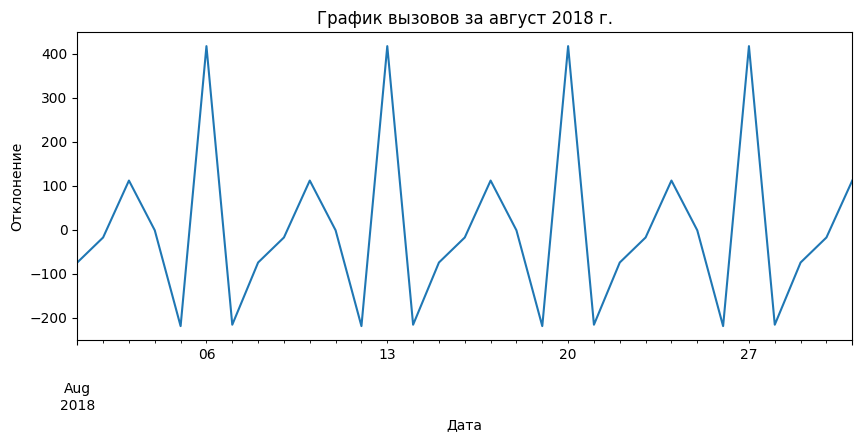

In [21]:
decomposed_week = seasonal_decompose(day)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title("График вызовов за август 2018 г.")
plt.xlabel('Дата')
plt.ylabel('Отклонение')
plt.show()

Наблюдаются ярко выраженные пики по понедельникам и спады в воскресенья и вторники. думаю это связано больше с рабочими командировками и возвращением людей из поездок.

Построим скользящее среднее и скользящее стандартное отклонение.

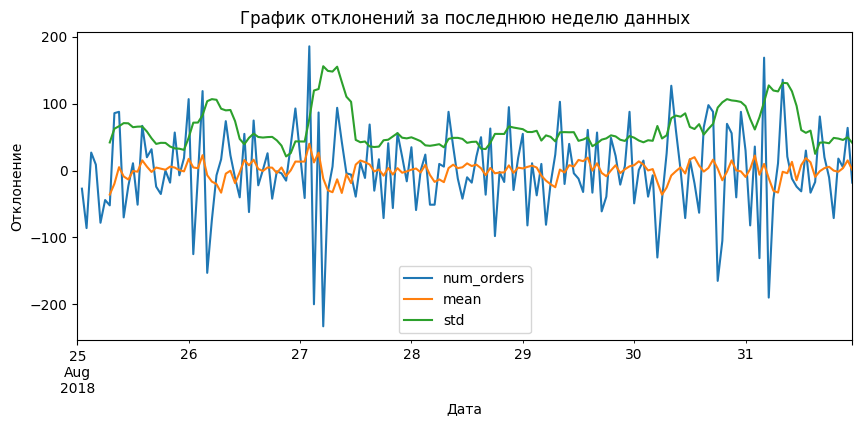

In [22]:
df -= df.shift() # < напишите код здесь >
df['mean'] = df['num_orders'].rolling(7).mean()
df['std'] = df['num_orders'].rolling(7).std()
df.plot()
plt.title("График отклонений за последнюю неделю данных")
plt.xlabel('Дата')
plt.ylabel('Отклонение')
plt.show()

Наблюдается рост отклонения в положительную сторону 27.08.2018 г. Думаю это связано с каким-то событием, либо прилетом дополнительных рейсов.

В анализе данных сделано следующее:
- Произведено ресемплирование по 1 часу.
- Выяснено, чтозначально с марта по июль особой разницы не наблюдается, количество заказов примерно одинаковое. В августе же количество заказов значительно выросло. Предполагаю, что это связано с каким-то внешним фактором. Нужно уточнить информацию у заказчика.
- В помесячном распределении наблюдается рост заказов, это хороший показатель, означающий, что компания развивается.
- На графиках прослеживается одна очень важная тенденция. После 21-00 и до 05-00 большое количество вызовов такси, в то же время ежедневно в 6-00 наблюдается очень сильный спад заказов. Думаю это связано с работой общественного транспорта, который как раз в 06-00 начинает свою работу и заканчивает в 21-00. Ночью насколько мне известно общественный транспорт тоже ходит в аэропорт и наверное с этим связан спад заказов в определенные часы (около 2-х часов ночи).
- Наблюдаются ярко выраженные пики по понедельникам и спады в воскресенья и вторники. думаю это связано больше с рабочими командировками и возвращением людей из поездок.
- Наблюдается рост отклонения в положительную сторону 27.08.2018 г. Думаю это связано с каким-то событием, либо прилетом дополнительных рейсов.

## Шаг 3. Обучение моделей.

Подготовим данные для обучения моделей.

Разобьем выборку на тренировочную и тестовую, соотношение 90:10.

In [23]:
max_lag = 24
rolling_mean_size = 24
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, max_lag, rolling_mean_size)
data = data.dropna()

Проведем сброс индекса.

In [24]:
#data = data.reset_index(drop=True)

In [25]:
RANDOM_STATE = 42
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=RANDOM_STATE) 

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Тренировачная выборка получилась за период с 1 марта по 13 августа. Тестовая с 13 августа по 31 августа.

Выделем таргет для предсказания.

In [26]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [27]:
X_train.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [28]:
X_test.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 16:00:00,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,139.541667
2018-08-13 17:00:00,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,139.166667
2018-08-13 18:00:00,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,...,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,140.708333
2018-08-13 19:00:00,0,19,104.0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,...,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,141.791667
2018-08-13 20:00:00,0,20,91.0,104.0,152.0,144.0,175.0,102.0,119.0,92.0,...,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,142.166667


Проведем кодировку данных.

In [29]:
X_test.columns

Index(['dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean'],
      dtype='object')

In [30]:
data['rolling_mean'].unique()

array([ 56.83333333,  55.41666667,  56.875     , ..., 167.54166667,
       168.04166667, 166.41666667])

In [31]:
cat_col_names = []
cat_col_names_oe = ['hour', 'dayofweek']
num_col_names = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean']

In [32]:
#One-Hot Encoding
#encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
#X_test_ohe = encoder.transform(X_test[cat_col_names])

#encoder_col_names = encoder.get_feature_names_out()

ordinal = OrdinalEncoder()

#OrdinalEncoding
X_train_oe = ordinal.fit_transform(X_train[cat_col_names_oe])
X_test_oe = ordinal.fit_transform(X_test[cat_col_names_oe])

#ordinal_col_names = ordinal.get_feature_names_out()

#StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
#Соединим данные в единый датафрейм
#X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names, index=X_train.index)
#X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=X_test.index)

X_train_oe = pd.DataFrame(X_train_oe, columns=cat_col_names_oe, index=X_train.index)
X_test_oe = pd.DataFrame(X_test_oe, columns=cat_col_names_oe, index=X_test.index)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names, index=X_test.index)

X_train = pd.concat([X_train_oe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_oe, X_test_scaled], axis=1)

In [33]:
# код показывающий актуальную версию sklearn на платформе
!pip show scikit-learn

Name: scikit-learn
Version: 0.24.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\users\almuc\anaconda3\envs\practicum\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: shap


In [34]:
X_train.shape, X_test.shape

((3952, 27), (440, 27))

В обучении моделей проведено следующее:
- Дата разбита на лаги, максимум выбрано 24 лага, т.к. в сутках 24 часа, а задача выяснить часы пик.
- Разбили выборку на тренировочную и тестовую, соотношение 90:10.
- Проведено кодирование данных с помощью OrdinalEncoder и StandardScaler.

**Linear Regression**

In [35]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
model_lr1 = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
parameters_lr = {}
model_lr = GridSearchCV(estimator=model_lr1,  cv=tscv, param_grid=parameters_lr, scoring='neg_mean_squared_error')
model_lr.fit(X_train, y_train)
start = time()
model_lr.best_estimator_.fit(X_train, y_train)
end = time()
time_lr = (end-start)

mse_model_lr = ((model_lr.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров LinearRegression:", model_lr.best_params_)
print()
print("RSME модели LinearRegression:", mse_model_lr)

start1 = time()
preds_model_lr = model_lr.best_estimator_.predict(X_train)

end1 = time()
time_lr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров LinearRegression: {}

RSME модели LinearRegression: 27.365295671152207
CPU times: total: 62.5 ms
Wall time: 63 ms


**Регрессия DecisionTreeRegresso**

In [36]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
model_tr1 = DecisionTreeRegressor(max_depth=8, 
                              random_state=RANDOM_STATE) 

parameters_tr = {"max_depth": [None,3,5],
      "min_samples_split": np.arange(2, 6, 12),
      "min_samples_leaf" : np.arange(1, 5, 10)}

model_tr = GridSearchCV(estimator=model_tr1,  cv=tscv, param_grid=parameters_tr, scoring='neg_mean_squared_error')
model_tr.fit(X_train, y_train)

start = time()
model_tr.best_estimator_.fit(X_train, y_train)
end = time()
time_tr = (end-start)

mse_model_tr = ((model_tr.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров DecisionTreeRegressor:", model_tr.best_params_)
print()
print("RSME модели DecisionTreeRegressor:", mse_model_tr)

start1 = time()
preds_model_lr = model_lr.best_estimator_.predict(X_train)

end1 = time()
time_tr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров DecisionTreeRegressor: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

RSME модели DecisionTreeRegressor: 30.709367552916753
CPU times: total: 453 ms
Wall time: 455 ms


**Регрессия LGBMRegressor**

In [37]:
%%time

model_lgbm_1 = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=RANDOM_STATE)
parameters_lgbm = {
      'learning_rate': [0.1, 0.01],
      'n_estimators': [50, 100, 150],
      'max_depth': [4, 6],
      'colsample_bytree': [0.7, 0.8],
      'subsample': [0.7, 0.8],
      'min_child_samples': [1, 5]}

model_lgbm = GridSearchCV(estimator=model_lgbm_1,  cv=tscv, param_grid=parameters_lgbm, scoring='neg_mean_squared_error')
model_lgbm.fit(X_train, y_train)

start = time()
model_lgbm.best_estimator_.fit(X_train, y_train)
end = time()
time_lgbm = (end-start)

mse_model_lgbm = ((model_lgbm.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров LGBMRegressor:", model_lgbm.best_params_)
print()
print("RSME модели LGBMRegressor:", mse_model_lgbm)

start1 = time()
preds_model_lgbm = model_lgbm.best_estimator_.predict(X_train)

end1 = time()
time_lgbm_pred = (end1-start1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 27
[LightGBM] [Info] Start training from score 57.057402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

**Регрессия CatBoostRegressor**

In [38]:
%%time

model_cat1 = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

model_cat = GridSearchCV(estimator=model_cat1,  cv=tscv, param_grid=parameters, scoring='neg_mean_squared_error')
model_cat.fit(X_train, y_train)

start = time()
model_cat.best_estimator_.fit(X_train, y_train)
end = time()
time_cat = (end-start)

mse_model_cat = ((model_cat.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров CatBoostRegressor:", model_cat.best_params_)
print()
print("RSME модели CatBoostRegressor:", mse_model_cat)

start1 = time()
preds_model_cat = model_cat.best_estimator_.predict(X_train)

end1 = time()
time_cat_pred = (end1-start1)

Оптимальная комбинация гиперпараметров CatBoostRegressor: {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

RSME модели CatBoostRegressor: 24.636283671906178
CPU times: total: 3min 57s
Wall time: 1min 38s


**Регрессия DummyRegressor**

In [39]:
%%time

dummy_regr1 = DummyRegressor(strategy="mean")
parameters = {}
dummy_regr = GridSearchCV(estimator=dummy_regr1,  cv=tscv, param_grid=parameters, scoring='neg_mean_squared_error')
dummy_regr.fit(X_train, y_train)

start = time()
dummy_regr.best_estimator_.fit(X_train, y_train)
end = time()
time_dummy = (end-start)

mse_model_dummy = ((dummy_regr.best_score_)*-1)**0.5
print("Оптимальная комбинация гиперпараметров DummyRegressor:", dummy_regr.best_params_)
print()
print("RSME модели DummyRegressor:", mse_model_dummy)

start1 = time()
preds_model_dummy = dummy_regr.best_estimator_.predict(X_train)

end1 = time()
time_dummy_pred = (end1-start1)

Оптимальная комбинация гиперпараметров DummyRegressor: {}

RSME модели DummyRegressor: 41.40393521723973
CPU times: total: 15.6 ms
Wall time: 15 ms


In [40]:
taxi = [[time_lr, time_lr_pred, mse_model_lr],
        [time_tr, time_tr_pred, mse_model_tr],
        [time_lgbm, time_lgbm_pred, mse_model_lgbm],
        [time_cat, time_cat_pred, mse_model_cat],
        [time_dummy, time_dummy_pred, mse_model_dummy]]
model_taxi = ["Linear Regression", "DecisionTreeRegressor", "LGBMRegressor", "CatBoostRegressor", "DummyRegressor"]

In [41]:
pd.DataFrame(data=taxi, index=model_taxi, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Linear Regression,0.004997,0.001998,27.365296
DecisionTreeRegressor,0.026981,0.002998,30.709368
LGBMRegressor,0.150894,0.017988,24.861026
CatBoostRegressor,7.449761,0.005996,24.636284
DummyRegressor,0.000999,0.000000,41.403935


    В обучении моделей было проведено следующее:
    - Построена модель Linear Regression. Время обучения 4 милисекунды, время предсказания 1 милисекунда. RMSE для линейной модели на валидационной выборке: 26
    - Построена модель DecisionTreeRegressor. Время обучения 46 милисекунд, время предсказания 3 милисекунды. RMSE для DecisionTreeRegresso модели на валидационной выборке: 29
    - Построена модель LGBMRegressor. Время обучения 71 милисекунда, время предсказания 10 милисекунд. RMSE для LGBMRegressor модели на валидационной выборке: 24
    - Построена модель CatBoostRegressor. Время обучения 5 секунд 25 милисекунд, время предсказания 4 милисекунды. RMSE для CatBoostRegressor модели на валидационной выборке: 24
    - В качестве сравнения построена модель DummyRegressor. Время обучения 0 милисекунд, время предсказания 0 милисекунд. RMSE для DummyRegressor модели на валидационной выборке: 41
    - Лучшими моделями являются LGBMRegressor и CatBoostRegressor.

## Шаг 4. Проверка на тестовой выборке.

Лучшей моделью по RSME и времени обучения является модель LGBMRegressor. Проведем проверку на тестовой выборке и сравним с моделью DummyRegressor.

**Регрессия LGBMRegressor**

In [42]:
%%time
start = time()
lgbm_predict1 = model_lgbm.best_estimator_.predict(X_test)
end = time()
time_lgbm_pred1 = (end-start)

CPU times: total: 15.6 ms
Wall time: 5 ms


In [43]:
mse_model_lgbm1 = mean_squared_error(y_test, lgbm_predict1) ** 0.5
print("RMSE для LGBMRegressor модели на тестовой выборке:", round((mse_model_lgbm1), 2))

RMSE для LGBMRegressor модели на тестовой выборке: 41.82


In [44]:
# посчитаем ошибки
mae_lgbm = mean_absolute_error(lgbm_predict1, y_test)
mse_lgbm = mean_squared_error(lgbm_predict1, y_test)
rmse_lgbm = mean_squared_error(lgbm_predict1, y_test, squared=False) 
r2_lgbm = r2_score(y_test, lgbm_predict1)

# выведем ошибки
print(f"R2 LGBMRegressor = {r2_lgbm:.2f}")
print(f"RSME = {rmse_lgbm:.0f}")
print(f'MSE = {mse_lgbm:.0f}')
print(f'MAE = {mae_lgbm:.0f}')
#Сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первая строка) = ', lgbm_predict1[0], 'Реальное значение (первая строка) = ', y_test.reset_index(drop = True)[0])

R2 LGBMRegressor = 0.49
RSME = 42
MSE = 1749
MAE = 31
Прогнозируемое значение (первая строка) =  159.33591403929438 Реальное значение (первая строка) =  144


**Регрессия DummyRegressor**

In [45]:
%%time
start = time()
dummy_predict1 = dummy_regr.best_estimator_.predict(X_test)
end = time()
time_dummy_pred1 = (end-start)

CPU times: total: 0 ns
Wall time: 0 ns


In [46]:
mse_model_dummy1 = mean_squared_error(y_test, dummy_predict1) ** 0.5
print("RMSE для DummyRegressor модели на тестовой выборке:", round((mse_model_dummy1), 2))

RMSE для DummyRegressor модели на тестовой выборке: 84.69


In [47]:
# посчитаем ошибки
mae_dummy = mean_absolute_error(dummy_predict1, y_test)
mse_dummy = mean_squared_error(dummy_predict1, y_test)
rmse_dummy = mean_squared_error(dummy_predict1, y_test, squared=False) 
r2_dummy = r2_score(y_test, dummy_predict1)

# выведем ошибки
print(f"R2 DummyRegressor = {r2_dummy:.2f}")
print(f"RSME = {rmse_dummy:.0f}")
print(f'MSE = {mse_dummy:.0f}')
print(f'MAE = {mae_dummy:.0f}')
#Сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первая строка) = ', dummy_predict1[0], 'Реальное значение (первая строка) = ', y_test.reset_index(drop = True)[0])

R2 DummyRegressor = -1.09
RSME = 85
MSE = 7172
MAE = 68
Прогнозируемое значение (первая строка) =  78.45141700404858 Реальное значение (первая строка) =  144


In [48]:
df1 = [[time_lgbm, time_lgbm_pred1, mae_lgbm, mse_lgbm, rmse_lgbm, r2_lgbm],
       [time_dummy, time_dummy_pred1, mae_dummy, mse_dummy, rmse_dummy, r2_dummy]]
model1 = ["CatBoostRegressor", "DummyRegressor"]

In [49]:
pd.DataFrame(data=df1, index=model1, columns=["fit_time", "predict_time", "MAE", "MSE", "RMSE", "R2"])

,fit_time,predict_time,MAE,MSE,RMSE,R2
CatBoostRegressor,0.150894,0.004995,31.403941,1748.909506,41.819965,0.491238
DummyRegressor,0.000999,0.000000,68.273969,7172.003630,84.687683,-1.086354


Лучшей моделью на тестовых данных является LGBMRegressor со следующими показателями:
- R2 LGBMRegressor = 0.52
- RSME = 41
- MSE = 1658
- MAE = 30
- Прогнозируемое значение (первая строка) =  152.08545682531368 Реальное значение (первая строка) =  144

Данная модель подходит под требование заказчика: "Значение метрики RMSE на тестовой выборке должно быть не больше 48." Также под требование подходит модель CatBoostRegressor.

## Шаг 5. Общий вывод.

При проведении прогнозирования количества заказов в компании «Чётенькое такси» было проведено следующее:
1. В анализе данных сделано следующее:
- Произведено ресемплирование по 1 часу.
- Выяснено, чтозначально с марта по июль особой разницы не наблюдается, количество заказов примерно одинаковое. В августе же количество заказов значительно выросло. Предполагаю, что это связано с каким-то внешним фактором. Нужно уточнить информацию у заказчика.
- В помесячном распределении наблюдается рост заказов, это хороший показатель, означающий, что компания развивается.
- На графиках прослеживается одна очень важная тенденция. После 21-00 и до 05-00 большое количество вызовов такси, в то же время ежедневно в 6-00 наблюдается очень сильный спад заказов. Думаю это связано с работой общественного транспорта, который как раз в 06-00 начинает свою работу и заканчивает в 21-00. Ночью насколько мне известно общественный транспорт тоже ходит в аэропорт и наверное с этим связан спад заказов в определенные часы (около 2-х часов ночи).
- Наблюдается рост отклонения в положительную сторону 27.08.2018 г. Думаю это связано с каким-то событием, либо прилетом дополнительных рейсов.
2. В анализе данных сделано следующее:
- Произведено ресемплирование по 1 часу.
- Выяснено, чтозначально с марта по июль особой разницы не наблюдается, количество заказов примерно одинаковое. В августе же количество заказов значительно выросло. Предполагаю, что это связано с каким-то внешним фактором. Нужно уточнить информацию у заказчика.
- В помесячном распределении наблюдается рост заказов, это хороший показатель, означающий, что компания развивается.
- На графиках прослеживается одна очень важная тенденция. После 21-00 и до 05-00 большое количество вызовов такси, в то же время ежедневно в 6-00 наблюдается очень сильный спад заказов. Думаю это связано с работой общественного транспорта, который как раз в 06-00 начинает свою работу и заканчивает в 21-00. Ночью насколько мне известно общественный транспорт тоже ходит в аэропорт и наверное с этим связан спад заказов в определенные часы (около 2-х часов ночи).
- Наблюдаются ярко выраженные пики по понедельникам и спады в воскресенья и вторники. думаю это связано больше с рабочими командировками и возвращением людей из поездок.
- Наблюдается рост отклонения в положительную сторону 27.08.2018 г. Думаю это связано с каким-то событием, либо прилетом дополнительных рейсов.
3. В обучении моделей проведено следующее:
- Дата разбита на лаги, максимум выбрано 24 лага, т.к. в сутках 24 часа, а задача выяснить часы пик.
- Разбили выборку на тренировочную и тестовую, соотношение 90:10.
- Проведено кодирование данных с помощью OrdinalEncoder и StandardScaler.
- также были построены следующие модели прогнозирования:
    - Построена модель Linear Regression. Время обучения 4 милисекунды, время предсказания 1 милисекунда. RMSE для линейной модели на валидационной выборке: 26
    - Построена модель DecisionTreeRegressor. Время обучения 46 милисекунд, время предсказания 3 милисекунды. RMSE для DecisionTreeRegresso модели на валидационной выборке: 29
    - Построена модель LGBMRegressor. Время обучения 71 милисекунда, время предсказания 10 милисекунд. RMSE для LGBMRegressor модели на валидационной выборке: 24
    - Построена модель CatBoostRegressor. Время обучения 5 секунд 25 милисекунд, время предсказания 4 милисекунды. RMSE для CatBoostRegressor модели на валидационной выборке: 24
    - В качестве сравнения построена модель DummyRegressor. Время обучения 0 милисекунд, время предсказания 0 милисекунд. RMSE для DummyRegressor модели на валидационной выборке: 41
    - Лучшими моделями являются LGBMRegressor и CatBoostRegressor.
4. Лучшей моделью на тестовых данных является LGBMRegressor со следующими показателями:
- R2 LGBMRegressor = 0.52
- RSME = 41
- MSE = 1658
- MAE = 30
- Прогнозируемое значение (первая строка) =  152.08545682531368 Реальное значение (первая строка) =  144

Данная модель подходит под требование заказчика: "Значение метрики RMSE на тестовой выборке должно быть не больше 48." Также под требование подходит модель CatBoostRegressor.